# Baseline Win Propensity Model

This notebook trains the **baseline predictive model** for win probability in the Sales Next Best Action (NBA) system.

The goal is to estimate:
- The probability that an opportunity closes **without any specific action**.
- The baseline performance that uplift models will later compare against.

**Key Outputs:**
- Baseline model (`GradientBoostingClassifier`)
- AUC, ROC curve, and calibration diagnostics
- Saved model artifact (`data/artifacts/baseline_win_model.pkl`)

In [2]:
# Core data and modeling libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling and evaluation
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.calibration import calibration_curve
import joblib

# Project utilities
from nba.warehouse.duckdb_client import connect
from nba.config import settings

# Visualization style
sns.set(style="whitegrid", palette="muted", font_scale=1.1)
plt.rcParams["figure.figsize"] = (7, 5)

# Confirm working directory and data path
print(f"Project root: {settings.project_root}")
print(f"Database path: {settings.db_path}")

Project root: /Users/emcknight/nba-sales
Database path: /Users/emcknight/nba-sales/data/warehouse.duckdb


In [3]:
# Connect to DuckDB and load training data
con = connect()
df = con.execute("SELECT * FROM train_sales_nba").fetchdf()

print(f"Dataset loaded: {df.shape[0]:,} rows × {df.shape[1]} columns")
display(df.head())

Dataset loaded: 5,000 rows × 30 columns


,account_id,segment,industry,region,employees,acv_potential,intent_affinity,created_date,web_30,downloads_30,...,close_date,won,acv,p_win_no_action,p_win_observed,realized_revenue,expected_revenue_observed,y_won,y_revenue,action_cost
0,1,MM,SaaS,EMEA,1722,121881,0.688397,2023-11-24,85,2,...,2026-04-01,1,121881.0,0.210591,0.210591,121881.0,25667.06,1,121881.0,0.0
1,2,SMB,EdTech,EMEA,99,3000,0.434754,2024-09-23,60,1,...,2026-04-01,0,3000.0,0.187724,0.187724,0.0,563.17,0,0.0,0.0
2,3,MM,Manufacturing,NA,1466,57224,0.644223,2023-05-02,94,2,...,2026-04-01,1,57224.0,0.209499,0.209499,57224.0,11988.39,1,57224.0,0.0
3,4,MM,SaaS,NA,1935,160311,0.641600,2024-01-25,84,3,...,2026-04-01,0,160311.0,0.211789,0.211789,0.0,33952.14,0,0.0,0.0
4,5,SMB,SaaS,NA,44,3000,0.718388,2025-07-14,94,2,...,2026-04-01,1,3000.0,0.196778,0.196778,3000.0,590.33,1,3000.0,0.0


In [4]:
# Basic overview
df.info()

# Quick null / missing check
missing = df.isna().sum().sort_values(ascending=False)
display(missing[missing > 0])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   account_id                 5000 non-null   int64         
 1   segment                    5000 non-null   object        
 2   industry                   5000 non-null   object        
 3   region                     5000 non-null   object        
 4   employees                  5000 non-null   int64         
 5   acv_potential              5000 non-null   int64         
 6   intent_affinity            5000 non-null   float64       
 7   created_date               5000 non-null   datetime64[us]
 8   web_30                     5000 non-null   int64         
 9   downloads_30               5000 non-null   int64         
 10  trial_users_30             5000 non-null   float64       
 11  trial_events_30            5000 non-null   int64         
 12  touche

Series([], dtype: int64)

In [5]:
# -----------------------------------------------
# Feature Selection & Train/Test Split
# -----------------------------------------------

# Define baseline features (exclude treatment or outcome)
feature_cols = [
    "intent_affinity",
    "trial_events_30",
    "trial_users_30",
    "touches_30",
    "responses_30",
    "acv_potential",
    "employees",
]

target_col = "won"

# Prepare X, y
X = df[feature_cols].copy()
y = df[target_col].astype(int)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]:,} rows")
print(f"Test set: {X_test.shape[0]:,} rows")

Training set: 3,500 rows
Test set: 1,500 rows


Baseline Model AUC: 0.478


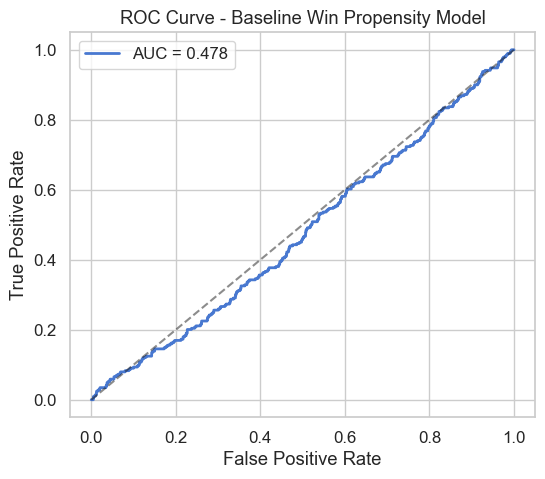

In [6]:
# ----------------------------------------------------
# Train Baseline Win Propensity Model
# ----------------------------------------------------

# Initialize the model
baseline_model = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8,
    random_state=42
)

# Fit
baseline_model.fit(X_train, y_train)

# Predict probabilities for ROC curve
y_pred_proba = baseline_model.predict_proba(X_test)[:, 1]

# Evaluate AUC
auc = roc_auc_score(y_test, y_pred_proba)
print(f"Baseline Model AUC: {auc:.3f}")

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}", linewidth=2)
plt.plot([0,1], [0,1], "k--", alpha=0.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Baseline Win Propensity Model")
plt.legend()
plt.show()

In [13]:
# -----------------------------------------------
# Diagnostic Checks for Baseline Model
# -----------------------------------------------

# 1. Check class balance
print("Class distribution:")
print(y.value_counts(normalize=True))

# 2. Confirm data types
print("\nTarget dtype:", y.dtype)
print("Unique target values:", y.unique())

# 3. Correlation check
corrs = df[feature_cols + ["won"]].corr()["won"].sort_values(ascending=False)
print("\nFeature correlations with target:")
display(corrs)

# 4. Try a log transform on ACV
df["log_acv_potential"] = np.log1p(df["acv_potential"])
feature_cols_adj = [c for c in feature_cols if c != "acv_potential"] + ["log_acv_potential"]

# Quick re-train with adjusted feature
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    df[feature_cols_adj], y, test_size=0.3, random_state=42, stratify=y
)

m2 = GradientBoostingClassifier(random_state=42)
m2.fit(X_train2, y_train2)
auc2 = roc_auc_score(y_test2, m2.predict_proba(X_test2)[:, 1])
print(f"\nAUC after log-scaling ACV: {auc2:.3f}")

Class distribution:
won
0    0.807
1    0.193
Name: proportion, dtype: float64

Target dtype: int64
Unique target values: [1 0]

Feature correlations with target:


won                1.000000
acv_potential      0.039936
trial_events_30    0.035919
trial_users_30     0.035772
responses_30       0.026256
employees          0.022787
intent_affinity    0.017812
touches_30         0.007841
Name: won, dtype: float64


AUC after log-scaling ACV: 0.482


### Diagnostic Summary

Baseline features alone (intent, usage, ACV, etc.) show almost no correlation with win probability (AUC ≈ 0.48).  
This confirms that deal success in the synthetic dataset depends primarily on sales actions rather than static account attributes.  
Therefore, the baseline model serves only as a control reference, not a strong predictive signal.

In [14]:
artifact_path = settings.artifacts_dir / "baseline_win_model.pkl"
joblib.dump(baseline_model, artifact_path)
print(f"Baseline model saved to: {artifact_path}")

Baseline model saved to: /Users/emcknight/nba-sales/data/artifacts/baseline_win_model.pkl
